In [1]:
import pandas as pd
import numpy as np
import math
import glob
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import cooler
from src.Graph_creation import compute_nx_graph_from_regions, compute_ptg_graph_from_regions,compute_ptg_graph_from_sites

In [2]:
coolerpath ={'WT':'/disk2/dh486/cooler_files/WT/manually_downsampled/KR/KR_downsampled_WT_merged_10000.cool',
             'KO':'/disk2/dh486/cooler_files/KO/KR/KR_KO_merged_10000.cool'
            }

In [7]:
x = pd.read_table("Data/archive/rnaseq.tsv")

x = x[x.columns[:5]]
x.columns = ['chromosome','start','end','target','name']
x.to_csv("Data/raw/target.tsv",sep="\t",index = False)

In [3]:
x, bad_sites = compute_ptg_graph_from_sites([coolerpath['WT'],coolerpath['KO']],
                                   {'chr2':np.array([10658971,11658978,13658978,15658978,17658978]),
                                    'chr3':np.array([8651256,10658971,10678978,11658978])
                                   },
                                   names = {'chr2': ['Ppp2r2c','reg2','reg3','reg4','reg5'],
                                            'chr3': ['Ppp3r3c','reg4','reg6','reg7']
                                           },
                                   balance = True, 
                                   join = False,
                                 record_cistrans_interactions = False,
                                   record_node_chromosome_as_onehot = False
                                  )

x

{'chr2': {'edge_index': array([[0., 0., 1., 1., 1., 1., 2., 2., 3., 4., 4.],
         [0., 1., 0., 1., 2., 4., 1., 2., 3., 1., 4.]]),
  'edge_attrs': array([[ 68.54391516, 132.44437687],
         [  5.29613656,   0.        ],
         [  5.29613656,   0.        ],
         [ 62.14922729, 125.54026079],
         [  0.        ,   1.07064205],
         [  1.95063539,   0.        ],
         [  0.        ,   1.07064205],
         [ 50.34215202, 159.66910041],
         [ 33.88699289, 159.50590195],
         [  1.95063539,   0.        ],
         [ 36.36661776, 108.50997462]]),
  'x': array([], shape=(1, 0), dtype=float64),
  'cooler_idxs': [array([20613, 20713, 20913, 21113, 21313])],
  'name': array(['Ppp2r2c', 'reg2', 'reg3', 'reg4', 'reg5'], dtype='<U7')},
 'chr3': {'edge_index': array([[0., 0., 0., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3., 3.],
         [0., 2., 3., 1., 2., 3., 0., 1., 2., 3., 0., 1., 2., 3.]]),
  'edge_attrs': array([[ 48.69851365, 110.72743322],
         [  1.24798179, 

In [4]:
bad_sites['chr2']

array([], dtype=int64)

In [5]:
x = compute_ptg_graph_from_regions([coolerpath['WT'],coolerpath['KO']],
                                   {'chr2':np.array([[8651256,10658971],
                                                     [10678978,11658978],
                                                     [12678978,13658978],
                                                     [14678978,15658978],
                                                     [16678978,17658978]
                                                    ]),
                                    'chr3':np.array([[8651256,10658971],
                                                     [10678978,11658978]
                                                    ])
                                   },
                                   names = {'chr2': ['Ppp2r2c','reg2'],
                                            'chr3': ['Ppp3r3c','reg4']
                                           },
                                   balance = True, 
                                   join = False,
                                   backbone = True,
                                   record_backbone_interactions = True,
                                   record_cistrans_interactions = False,
                                   record_node_chromosome_as_onehot = False
                                  )

x

{'chr2': [{'edge_index': array([[  0.,   0.,   0., ..., 200., 200., 200.],
          [  0.,   1.,   2., ..., 198., 199., 200.]]),
   'edge_attrs': array([[ 45.51099203, 138.71464153,   0.        ],
          [ 71.47081371, 144.8921595 ,   1.        ],
          [ 29.6403106 ,  50.38548857,   0.        ],
          ...,
          [ 41.5707432 ,  67.55735544,   0.        ],
          [113.3756405 , 151.55135175,   1.        ],
          [ 68.54391516, 132.44437687,   0.        ]]),
   'x': array([], shape=(2, 0), dtype=float64),
   'cooler_idxs': array([20413, 20414, 20415, 20416, 20417, 20418, 20419, 20420, 20421,
          20422, 20423, 20424, 20425, 20426, 20427, 20428, 20429, 20430,
          20431, 20432, 20433, 20434, 20435, 20436, 20437, 20438, 20439,
          20440, 20441, 20442, 20443, 20444, 20445, 20446, 20447, 20448,
          20449, 20450, 20451, 20452, 20453, 20454, 20455, 20456, 20457,
          20458, 20459, 20460, 20461, 20462, 20463, 20464, 20465, 20466,
          2046

In [6]:
def draw_circular(graph, ax, cmap = plt.cm.Blues, weightnorm = None):
    pos = nx.circular_layout(graph)
    #nx.draw_networkx_nodes(graph, pos = pos,node_size=30,ax=ax)

    edges,weights = zip(*nx.get_edge_attributes(graph,'weight').items())

    if weightnorm is None:
        weightnorm = np.percentile(weights,90)
    normalize = mpl.colors.Normalize(vmin=0, vmax=weightnorm)
    for jdx in np.argsort(weights):
        nx.draw_networkx_edges(graph, 
                           pos, 
                           ax = ax,
                           edgelist=[edges[jdx]], 
                           edge_color = cmap(normalize(weights[jdx])), 
                           connectionstyle='arc3,rad=0.3')

    labels = {item[0]: item[1].split(":")[1].split("-")[0] for item in graph.nodes(data='bin_regions') if int(item[0])%20 == 0}
    poslabels = nx.draw_networkx_labels(graph,{key: 1.1*pos[key] for key in pos},labels = labels,ax= ax)
    
    return weightnorm, pos

def highlight_nodes(graph, nodes,ax, pos, **kwargs):
    nx.draw_networkx_nodes(graph, pos = pos,ax=ax, **kwargs)
    
def compare_gene(gene_reg, gene_name):
    gene_intregs = gene_reg.split(":")[1]
    gene_intregs = [int(item.replace(',', '')) for item in gene_intregs.split("-")]
    c = cooler.Cooler(coolerpath['WT'])
    mynodes = c.bins().fetch(gene_reg).index.values

    regions = {
        gene_reg.split(":")[0]: np.array([[gene_intregs[0]-int(4e5),gene_intregs[1]+int(4e5)]])
    }
    chrom = gene_reg.split(":")[0]
    graphs = {cond: compute_nx_graph_from_regions(coolerpath[cond],
                                                  regions,
                                                  join= True,
                                                  force_disjoint = True,
                                                  balance = True) for cond in ['WT','KO']}

    fig, ax = plt.subplots(1,2, figsize = (16,8))
    fig.tight_layout()
    for idx in [0,1]:
        ax[idx].spines['left'].set_visible(False)
        ax[idx].spines['right'].set_visible(False)
        ax[idx].spines['top'].set_visible(False)
        ax[idx].spines['bottom'].set_visible(False)
    
    pos = {}
    KO_weightnorm,pos['KO'] = draw_circular(graphs['KO'],
                                        ax[0],
                                        cmap = plt.cm.Reds)
    ax[0].set_title(f"KO contacts\n{graphs['KO'].graph['regions']}\n{gene_name} highlighted",
                size = 15)

    nx.draw_networkx_nodes(graphs['KO'],
                       pos = pos['KO'],
                       ax=ax[0],
                       node_size = 50, 
                       node_color = 'yellow', 
                       nodelist = mynodes)

    WT_weightnorm, pos['WT'] = draw_circular(graphs['WT'],
                                         ax[1],
                                         weightnorm = KO_weightnorm)
    ax[1].set_title(f"WT contacts\n{graphs['WT'].graph['regions']}\n{gene_name} highlighted",
                size = 15)
    nx.draw_networkx_nodes(graphs['WT'],
                       pos = pos['WT'],
                       ax=ax[1],
                       node_size = 50, 
                       node_color = 'yellow', 
                       nodelist = mynodes)

    for idx in [0,1]:
        ax[idx].set_xlim([-1.3,1.2])
        ax[idx].set_ylim([-1.2,1.2])
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])


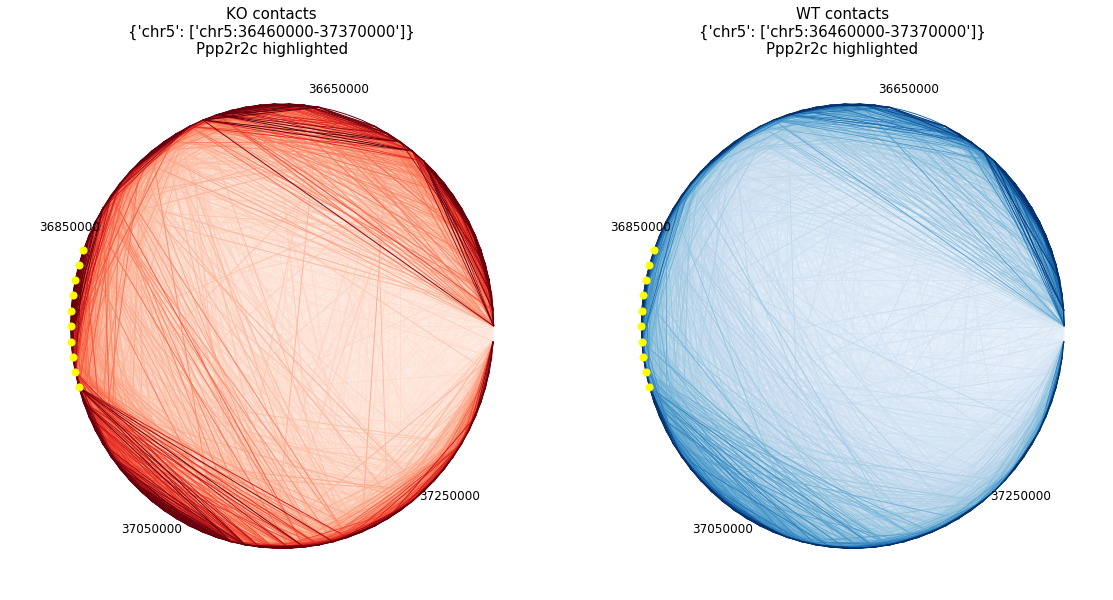

In [7]:
compare_gene(gene_reg = "chr5:36,868,513-36,955,078",gene_name = 'Ppp2r2c')

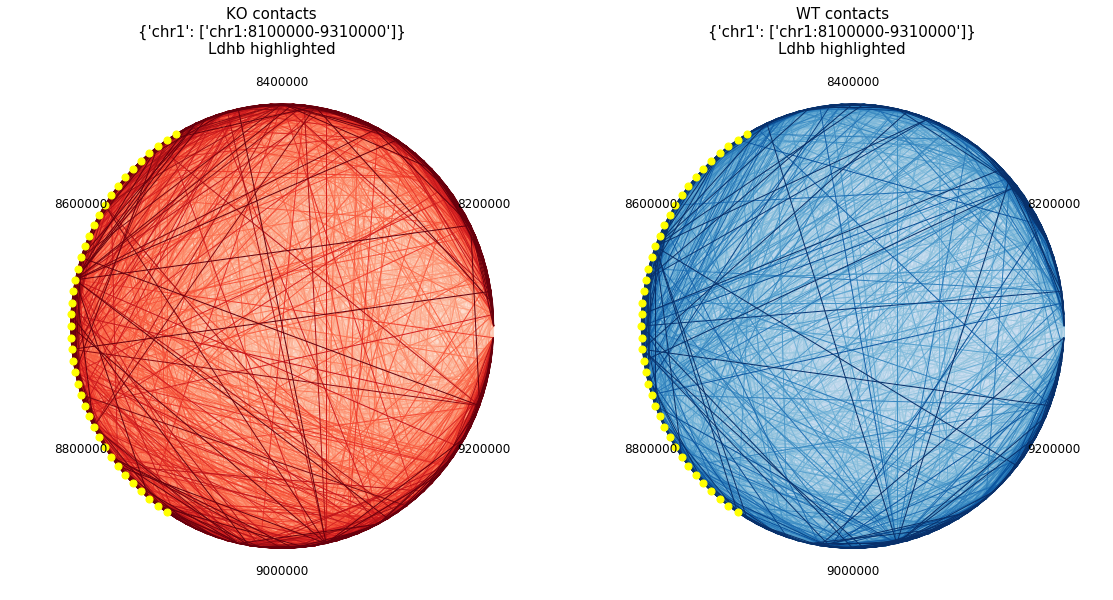

In [8]:
compare_gene(gene_reg = 'chr1:8,500,000-8,900,000',gene_name = 'Ldhb')

In [9]:
graphs = compute_nx_graph_from_regions(coolerpath['WT'],
                                       {'chr1':np.array([[8100000,9310000],
                                                         [9340000,10110000]]),
                                        'chr2':np.array([[8100000,9310000],
                                                         [9340000,10110000]]),
                                        'chr3':np.array([[8100000,9310000],
                                                         [9340000,10110000]])
                                       },
                                       balance = True, join = True, force_disjoint = True)



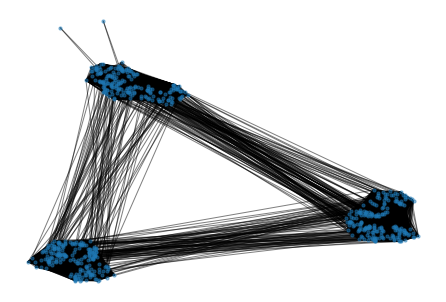

In [10]:
nx.draw(graphs,node_size = 10,alpha = 0.5)

In [11]:
graphs = compute_nx_graph_from_regions(coolerpath['WT'],
                                       {'chr1':np.array([[8100000,9310000],
                                                         [9340000,10110000]]),
                                        'chr2':np.array([[8100000,9310000],
                                                         [9340000,10110000]]),
                                        'chr3':np.array([[8100000,9310000],
                                                         [9340000,10110000]])
                                       },
                                       balance = True)



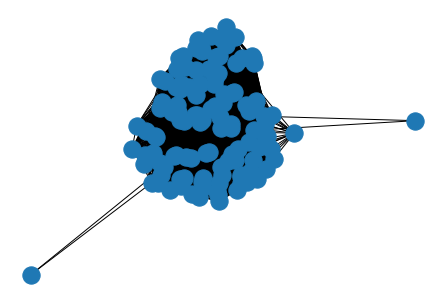

In [12]:
nx.draw(graphs['chr1']['chr1'][0])

In [6]:
def symlog(arr):
    out = arr.copy()
    out[out>1] = 1 + np.log(out[out>1])
    
    return out

In [23]:
tmp = pd.read_csv("Data/KR_downsampled_WT_merged_10000_bw_data.tsv",
            sep="\t", index_col = 0)
#tmp = tmp[tmp['id']!='intergenic']

arr = tmp.values.astype('float')
'''
arr = symlog(arr) 

norm = (np.repeat(np.max(arr,
                         axis = 0)[None,:],
                   arr.shape[0],
                   axis = 0
                   )
)

arr = arr/norm

plt.imshow(arr, aspect = 'auto')
plt.xticks(np.arange(15)-0.5,tmp.columns.values, rotation = 60)
'''

"\narr = symlog(arr) \n\nnorm = (np.repeat(np.max(arr,\n                         axis = 0)[None,:],\n                   arr.shape[0],\n                   axis = 0\n                   )\n)\n\narr = arr/norm\n\nplt.imshow(arr, aspect = 'auto')\nplt.xticks(np.arange(15)-0.5,tmp.columns.values, rotation = 60)\n"

In [24]:
from sklearn.preprocessing import PowerTransformer as PT
from sklearn.preprocessing import StandardScaler as SS
from sklearn.preprocessing import RobustScaler as RS

Text(0.5, 0, 'Power\nTransformer')

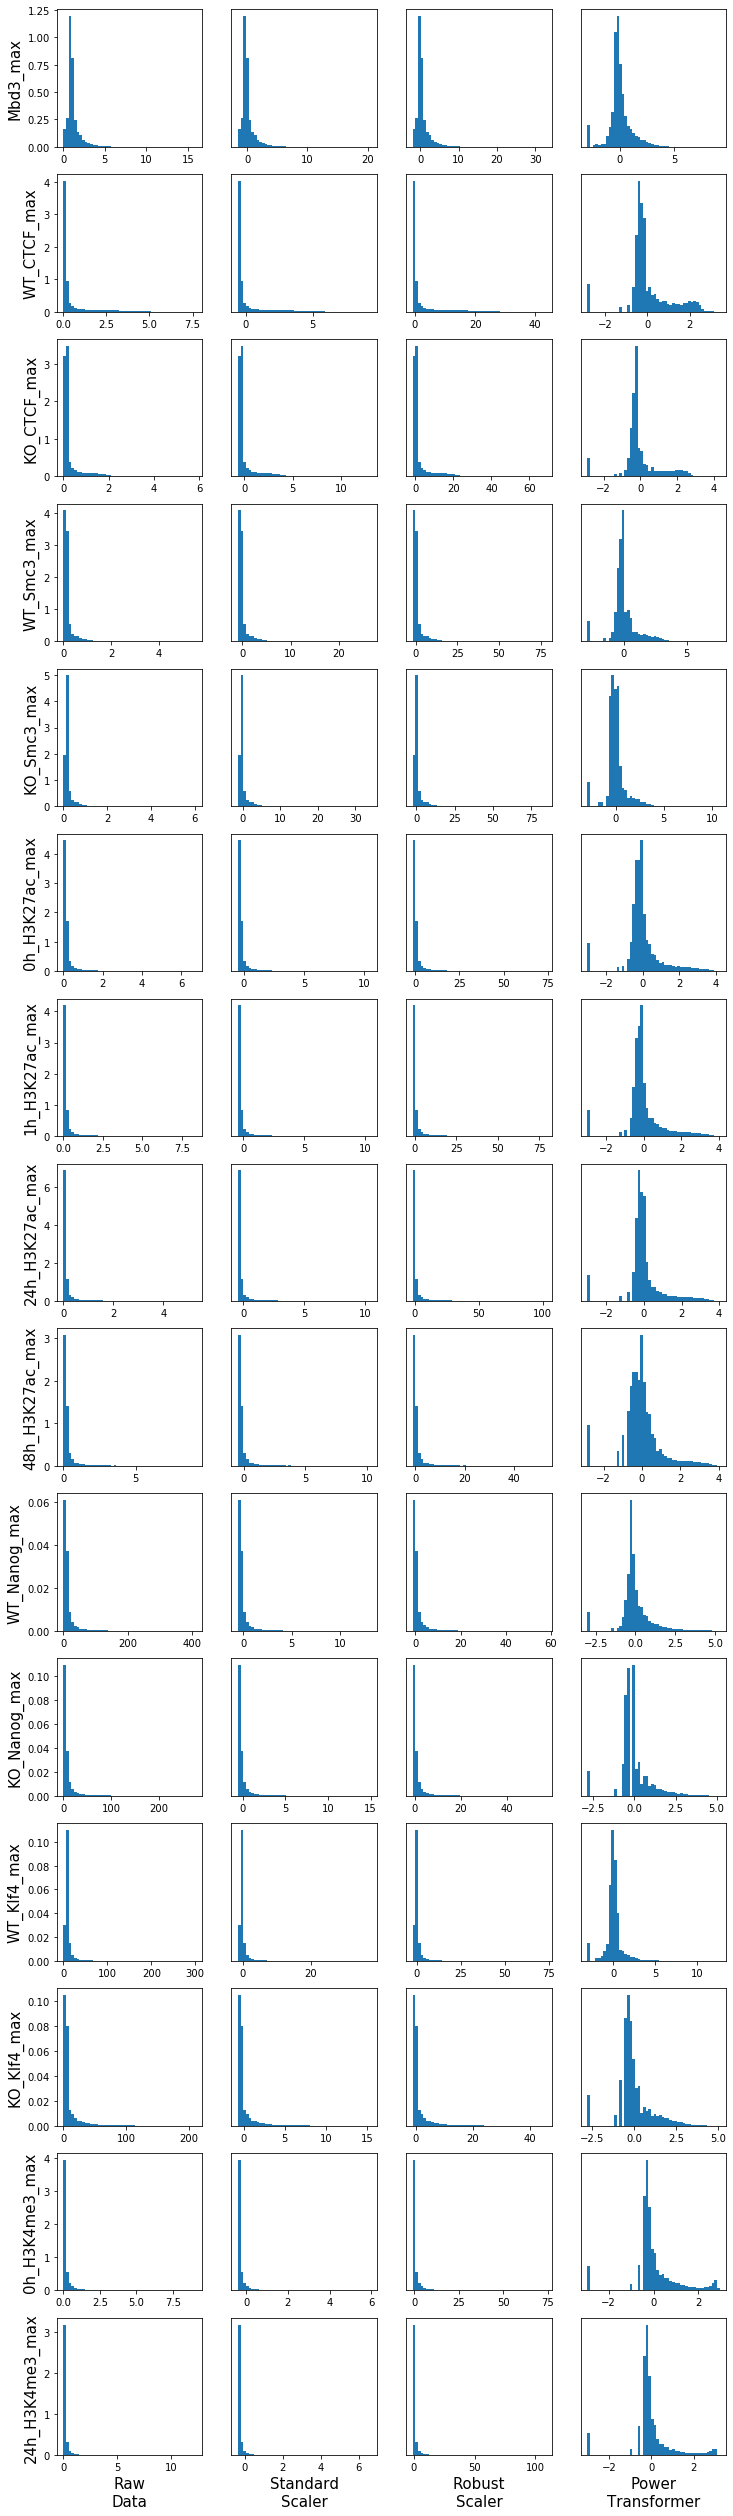

In [25]:
fig, ax = plt.subplots(15,4,figsize = (12,45))

scalerSS = SS()
scalerSS.fit(arr)
arrSS = scalerSS.transform(arr)
scalerRS = RS()
scalerRS.fit(arr)
arrRS = scalerRS.transform(arr)
scalerPT = PT(method = 'box-cox')
scalerPT.fit(arr+0.01*np.min(arr[arr>0]))
arrPT = scalerPT.transform(arr+0.01*np.min(arr[arr>0]))

for jdx in np.arange(15):
    ax[jdx,0].set_ylabel(tmp.columns.values[jdx],
                         size = 15)
    ax[jdx,0].hist(arr[:,jdx],
                   bins = 50,
                   density =True)
    ax[jdx,1].hist(arrSS[:,jdx],
                   bins = 50,
                   density=True)
    ax[jdx,2].hist(arrRS[:,jdx],
                   bins = 50,
                   density=True)
    ax[jdx,3].hist(arrPT[:,jdx],
                   bins = 50,
                   density =True)
    
    for idx in [1,2,3]:
        ax[jdx,idx].set_yticks([])
        
ax[-1,0].set_xlabel('Raw\nData',size = 15) 
ax[-1,1].set_xlabel('Standard\nScaler',size = 15) 
ax[-1,2].set_xlabel('Robust\nScaler',size = 15) 
ax[-1,3].set_xlabel('Power\nTransformer',size = 15) 

In [28]:
newdf = pd.DataFrame(data = arrPT, columns = tmp.columns.values)
newdf.to_csv("Data/PowerTransformed_KR_downsampled_WT_merged_10000_bw_data.tsv",sep="\t")

In [48]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    R = dendrogram(linkage_matrix, **kwargs)
    return R, counts

# setting distance_threshold=0 ensures we compute the full tree.
model1 = AgglomerativeClustering(distance_threshold=0,
                                 n_clusters=None,
                                 linkage='ward')

model1 = model1.fit(arr)

#setting distance_threshold=0 ensures we compute the full tree.
model2 = AgglomerativeClustering(distance_threshold=0, 
                                 n_clusters=None, 
                                 linkage = 'ward')

model2 = model2.fit(np.array(arr).T)

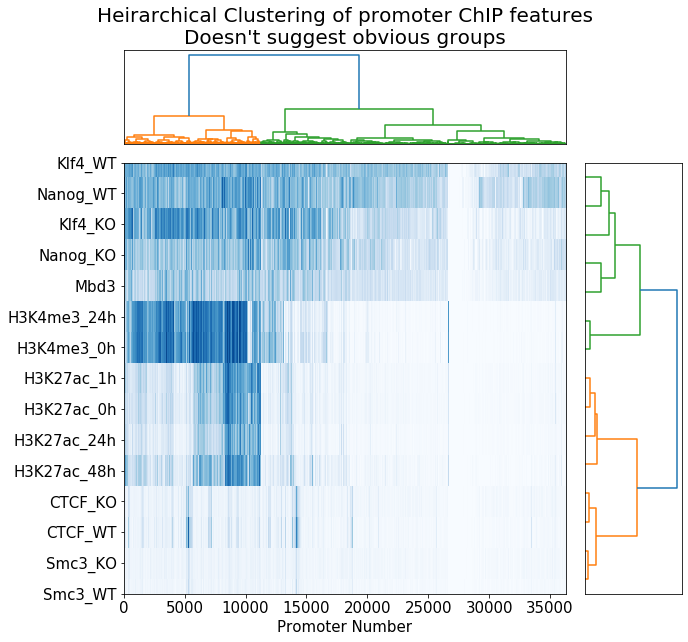

In [51]:
import sys
featnames = tmp.columns.values[7:]

sys.setrecursionlimit(2000)

fig = plt.figure(figsize = (10,10))
fig.tight_layout()

ax1 = plt.subplot2grid((5, 5), (1, 0), colspan=4, rowspan=4)
ax2 = plt.subplot2grid((5, 5), (0, 0), colspan=4)
ax3 = plt.subplot2grid((5, 5), (1, 4), rowspan=4)

ax2.xaxis.set_visible(False)
ax3.yaxis.set_visible(False)
ax2.yaxis.set_visible(False)
ax3.xaxis.set_visible(False)

R2 = plot_dendrogram(model2,
                     truncate_mode='level',
                     p=60,
                     get_leaves = True,
                     orientation = 'right',
                     ax = ax3,
                     distance_sort = 'ascending')[0]
R1 = plot_dendrogram(model1,
                     truncate_mode='level',
                     p=2000,
                     get_leaves = True,
                     orientation = 'top',
                     ax = ax2,
                     distance_sort = 'ascending')[0]

img1 = arr[np.array(R1['leaves']),:]
img1 = img1[:,np.array(R2['leaves'])[::-1]]

ax1.imshow(img1.T, 
           cmap = plt.cm.Blues, 
           vmin = 0, 
           vmax = 1, 
           aspect = 'auto')
reorderedtracks = [featnames[i] for i in np.array(R2['leaves'])[::-1]]
yticks = ax1.set_yticks(np.arange(len(reorderedtracks)))
yticklabs = ax1.set_yticklabels(reorderedtracks)
ax1.set_xlabel("Promoter Number", size = 15)
ax1.tick_params(labelsize = 15)
ax2.set_title("Heirarchical Clustering of promoter ChIP features\nDoesn't suggest obvious groups", size = 20)
for ax in [ax2,ax3]:
    ax.spines['top'].set_visible('false')
    ax.spines['bottom'].set_visible('false')
    ax.spines['left'].set_visible('false')
    ax.spines['right'].set_visible('false')
    

In [52]:
import umap
reducer = umap.UMAP(n_neighbors = 20, n_components = 2)
reducer.fit(arrPT)
arr_embedded = reducer.transform(arrPT)

/disk1/dh486/anaconda3/envs/hicexplorer/lib/python3.7/site-packages/umap/__init__.py:9: UserWarning:

Tensorflow not installed; ParametricUMAP will be unavailable



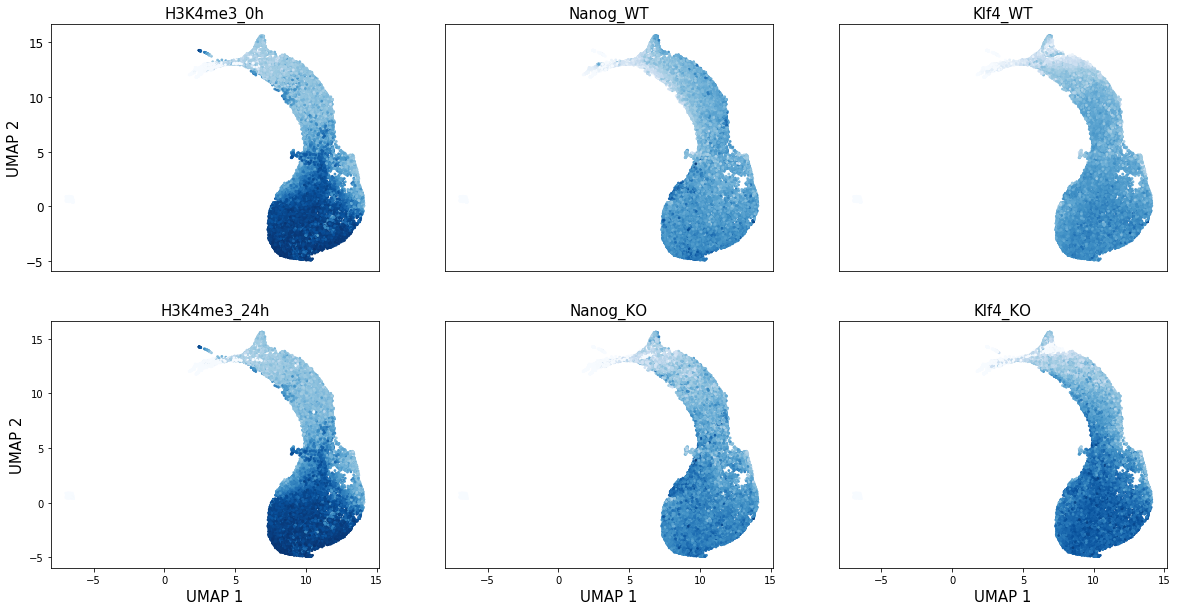

In [53]:
import matplotlib as mpl
fig = plt.figure(figsize = (20,10))
fig.tight_layout()

ax = []
ax.append(plt.subplot2grid((2, 3), (0, 0), colspan=1, rowspan=1))
ax.append(plt.subplot2grid((2, 3), (1, 0), colspan=1, rowspan=1))
ax.append(plt.subplot2grid((2, 3), (0, 1), colspan=1, rowspan=1))
ax.append(plt.subplot2grid((2, 3), (1, 1), colspan=1, rowspan=1))
ax.append(plt.subplot2grid((2, 3), (0, 2), colspan=1, rowspan=1))
ax.append(plt.subplot2grid((2, 3), (1, 2), colspan=1, rowspan=1))

names = ['H3K4me3_0h','H3K4me3_24h','Nanog_WT','Nanog_KO','Klf4_WT','Klf4_KO']
for idx, item in enumerate([np.where(featnames ==name)[0][0] for name in names]):
    cols = arrPT[:,item]
    ax[idx].scatter(arr_embedded[:,0], 
               arr_embedded[:,1],
               c= cols, 
               cmap = plt.cm.Blues,
               s= 3,
               label = "Hub") 
    
    ax[idx].set_title(names[idx],size = 15)

ax[0].tick_params(labelsize = 12)
ax[1].set_xlabel("UMAP 1", size = 15)
ax[3].set_xlabel("UMAP 1", size = 15)
ax[5].set_xlabel("UMAP 1", size = 15)
ax[1].set_ylabel("UMAP 2", size = 15)
ax[0].set_ylabel("UMAP 2", size = 15)

ax[0].get_xaxis().set_visible(False)
ax[2].get_xaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)    
ax[3].get_yaxis().set_visible(False)
ax[4].get_yaxis().set_visible(False)
ax[5].get_yaxis().set_visible(False)
ax[4].get_xaxis().set_visible(False)


Text(0.5, 1.0, 'Downregulated Genes\n(intensity = amount of downregulation)')

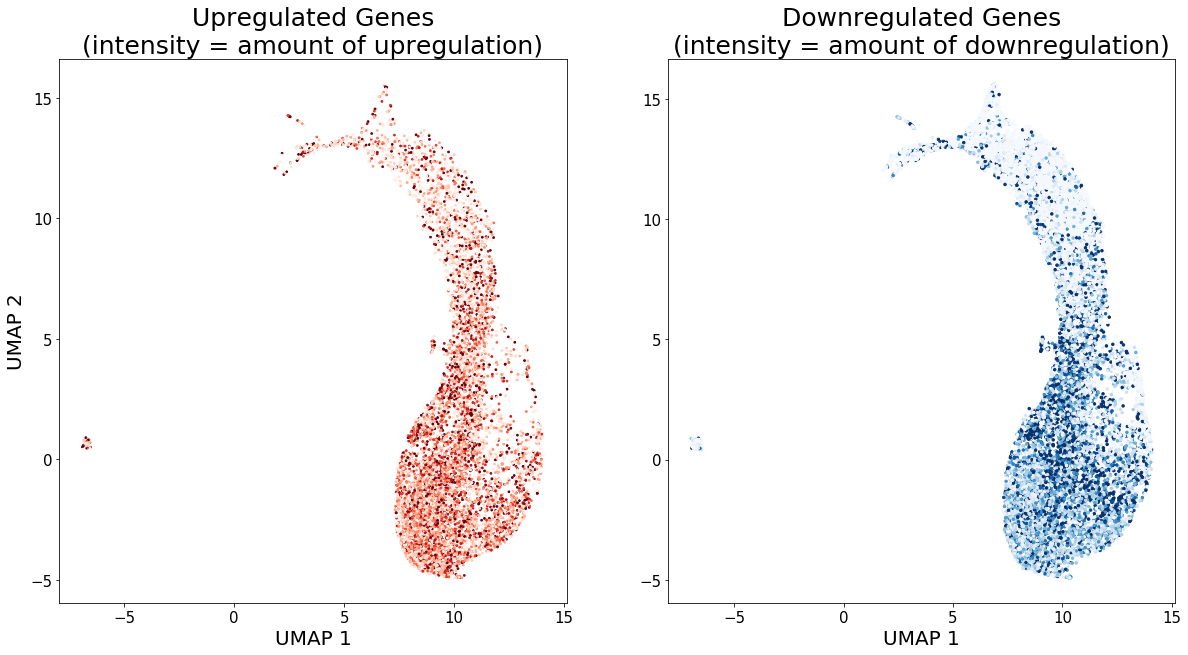

In [54]:
fig, ax = plt.subplots(1,2,figsize = (20,10))
cols = tmp['lfc_rnaseq']

idxs = cols>0
ax[0].scatter(arr_embedded[idxs,0],
           arr_embedded[idxs,1],
           c= cols[idxs],
           vmin = 0,
           vmax = np.percentile(cols[idxs],90),
           cmap = plt.cm.Reds,
           s= 3,
           label = "promoter")

idxs = cols<0
ax[1].scatter(arr_embedded[idxs,0],
           arr_embedded[idxs,1],
           c= cols[idxs],
           vmax = 0,
           vmin = np.percentile(cols[idxs],10),
           cmap = plt.cm.Blues_r,
           s= 6,
           label = "promoter")

for idx in [0,1]:
    ax[idx].spines['top'].set_visible('false')
    ax[idx].spines['bottom'].set_visible('false')
    ax[idx].spines['left'].set_visible('false')
    ax[idx].spines['right'].set_visible('false')
    ax[idx].set_xlabel("UMAP 1",size = 20)
    ax[idx].tick_params(labelsize = 15)
ax[0].set_ylabel("UMAP 2",size = 20)
ax[0].set_title("Upregulated Genes\n(intensity = amount of upregulation)",size = 25)
ax[1].set_title("Downregulated Genes\n(intensity = amount of downregulation)",size= 25)

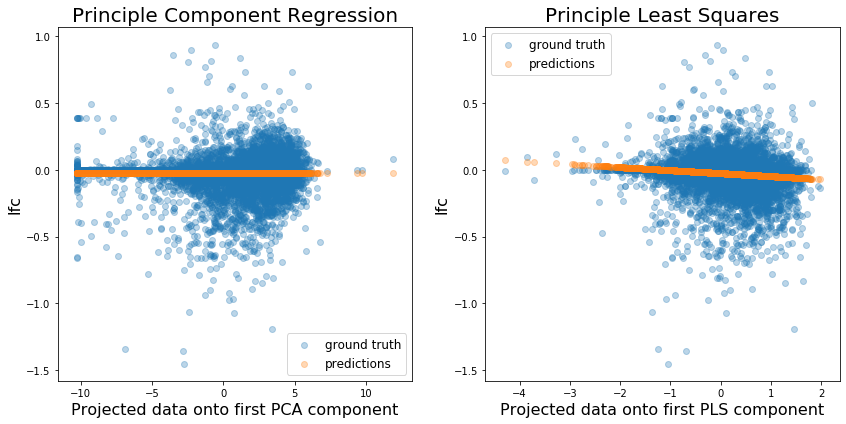

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

rng = np.random.RandomState(0)
X_train, X_test, y_train, y_test = train_test_split(arrPT, cols, random_state=rng)

pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps['pca']  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].scatter(pca.transform(X_test), y_test, alpha=.3, label='ground truth')
axes[0].scatter(pca.transform(X_test), pcr.predict(X_test), alpha=.3,
                label='predictions')
axes[0].set_xlabel('Projected data onto first PCA component',size = 16)
axes[0].set_ylabel('lfc', size = 16)
axes[0].set_title('Principle Component Regression',size = 20)
axes[0].legend(prop = {'size':12})

axes[1].scatter(pls.transform(X_test), y_test, alpha=.3, label='ground truth')
axes[1].scatter(pls.transform(X_test), pls.predict(X_test), alpha=.3,
                label='predictions')
axes[1].set_xlabel('Projected data onto first PLS component',size = 16)
axes[1].set_ylabel('lfc', size = 16)
axes[1].set_title('Principle Least Squares',size = 20)

axes[1].legend(prop = {'size':12})
plt.tight_layout()
plt.show()

In [103]:
from sklearn.linear_model import RidgeCV as RCV
regr = RCV()
regr.fit(arrPT, cols.values)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

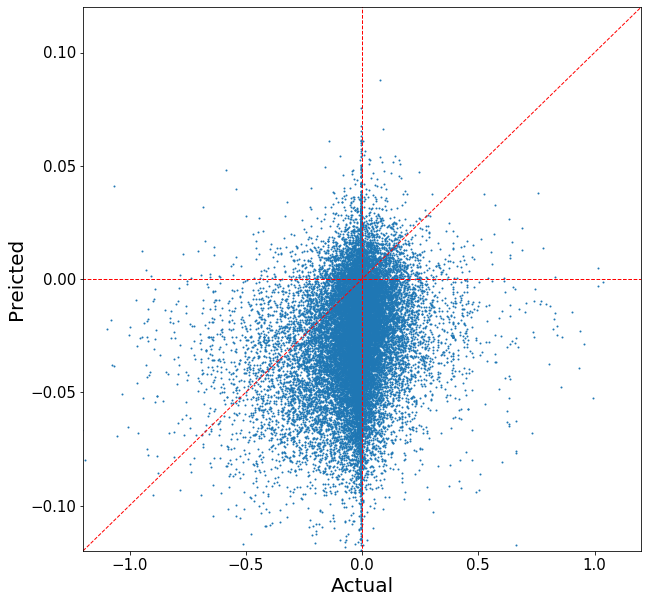

In [104]:
fig,ax = plt.subplots(1, figsize = (10,10))
ax.scatter(cols.values, 
           regr.predict(arrPT),
           s = 1)
ax.tick_params(labelsize = 15)
ax.set_xlabel("Actual",size = 20)
ax.set_ylabel("Preicted",size = 20)
ax.vlines(0,-0.25,0.15,linestyle = '--',linewidth = 1, color = 'red')
ax.hlines(0,-1.5,1.5,linestyle = '--',linewidth = 1, color = 'red')
ax.set_xlim([-1.2,1.2])
ax.set_ylim([-0.12,0.12])

xlim = ax.get_xlim()
ylim= ax.get_ylim()
plt.plot(xlim,ylim,linestyle = '--',linewidth = 1, color = 'red')

In [7]:
from glob import glob

glob("/disk1/dh486/Data/rnaseq/MBD3_wt_1_17520_ATCACG_kallisto_ncrna_ERCC92/*")

['/disk1/dh486/Data/rnaseq/MBD3_wt_1_17520_ATCACG_kallisto_ncrna_ERCC92/abundance_genes_norm.tsv',
 '/disk1/dh486/Data/rnaseq/MBD3_wt_1_17520_ATCACG_kallisto_ncrna_ERCC92/abundance_genes.tsv']

In [8]:
import pandas as pd
x = pd.read_table("/disk1/dh486/Data/rnaseq/kallisto_ncrna_ERCC92_wayne_processed_abundance_norm.txt", index_col = 5)

In [9]:
x

,chromosome,prom_start,prom_end,transcript_start,transcript_end,lfc,strand,log10KO_exp,log10WT_exp,name
ens_id,,,,,,,,,,
ENSMUSG00000000001,3,108145651,108147137,108107280,108146151,0.052546,-1,1.722002,1.774547,Gnai3
ENSMUSG00000000003,X,77853128,77854614,77837901,77853628,-0.002751,-1,0.001375,-0.001375,Pbsn
ENSMUSG00000000028,16,18811096,18812978,18780447,18811596,-0.112532,-1,1.700354,1.587822,Cdc45
ENSMUSG00000000031,7,142576415,142579134,142575529,142576915,0.528073,-1,0.460089,0.988163,H19
ENSMUSG00000000037,X,161161759,161163555,161163055,161258213,-0.474546,1,1.329332,0.854785,Scml2
...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000099329,17,29548808,29550294,29549794,29682012,-0.014677,1,0.013417,-0.001259,Gm28052
ENSMUSG00000099330,7,44537683,44539169,44538106,44538183,0.427555,-1,-0.002683,0.424872,Mir7053
ENSMUSG00000099331,11,46169096,46170582,46170082,46170143,-0.002751,1,0.001375,-0.001375,Mir7239


In [10]:
y = pd.read_table("Data/_candidate_elements.csv")

In [15]:
y

,chrom,start,end,id,WT_rnaseq,KO_rnaseq,lfc_rnaseq
0,chr1,4470904,4472493,intergenic,0.000000,0.000000,0.000000
1,chr1,4571442,4572012,intergenic,0.000000,0.000000,0.000000
2,chr1,4659374,4662004,intergenic,0.000000,0.000000,0.000000
3,chr1,4800080,4805026,intergenic,0.000000,0.000000,0.000000
4,chr1,4971591,4972402,intergenic,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
59720,chrY,90400257,90401743,promoter_ENSMUSG00000096178,-0.001375,0.001375,-0.002751
59721,chrY,90752066,90753552,promoter_ENSMUSG00000095134,0.183686,0.316517,-0.132830
59722,chrY,90754972,90756458,promoter_ENSMUSG00000095366,0.492786,0.510529,-0.017744
59723,chrY,90783747,90785233,promoter_ENSMUSG00000096768,2.662188,2.688566,-0.026378


In [19]:
bigwig_paths = {'Mbd3':'/disk2/dh486/bigwigs/GSEXXXXXHendrich20150626_Mbd3_ESC_treat_pileup_filter_norm.bw',
           'CTCF_WT': '/disk2/dh486/bigwigs/GSEXXXXXLaue_CTCF_dipmESC_treat_pileup_filter_norm.bw',
           'CTCF_KO':'/disk2/dh486/bigwigs/GSEXXXXXLaue_CTCF_MBD3nullESC_treat_pileup_filter_norm.bw',
           'Smc3_WT': '/disk2/dh486/bigwigs/GSEXXXXXLaue_Smc3_dipmESC_treat_pileup_filter_norm.bw',
           'Smc3_KO': '/disk2/dh486/bigwigs/GSEXXXXXLaue_Smc3_MBD3nullESC_treat_pileup_filter_norm.bw',
           'H3K27ac_0h': '/disk2/dh486/bigwigs/0h_H3K27ac_R1_ERR2588258.Q30.srt.nodup.bam_treat_pileup_filter_norm.bw',
           'H3K27ac_1h': '/disk2/dh486/bigwigs/1h_H3K27ac_R1_ERR2588281.Q30.srt.nodup.bam_treat_pileup_filter_norm.bw',
           'H3K27ac_24h':'/disk2/dh486/bigwigs/24h_H3K27ac_R2_ERR2588319.Q30.srt.nodup.bam_treat_pileup_filter_norm.bw',
           'H3K27ac_48h': '/disk2/dh486/bigwigs/48h_H3K27ac_R1_ERR2588355.Q30.srt.nodup.bam_treat_pileup_filter_norm.bw',
           'Nanog_WT': '/disk2/dh486/bigwigs/WT/GSE71932_Nanog_mESCs_treat_pileup_filter.bw',
           'Nanog_KO':'/disk2/dh486/bigwigs/KO/GSEXXXXXHendrich20150302_Nanog_Mbd3nullESC_treat_pileup_filter.bw',
           'Klf4_WT': '/disk2/dh486/bigwigs/WT/GSEXXXXXHendrich20150302_Klf4_ESC_treat_pileup_filter.bw',
           'Klf4_KO': '/disk2/dh486/bigwigs/KO/GSEXXXXXHendrich20150302_Klf4_Mbd3nullESC_treat_pileup_filter.bw',
           'H3K4me3_0h':'/disk1/wb104/chipseq/Hendrich_H3K4me3/ERR2588261.fastq.Q30.srt.nodup.bam_treat_pileup_filter_norm.bw',
           'H3K4me3_24h':'/disk1/wb104/chipseq/Hendrich_H3K4me3/ERR2588321.fastq.Q30.srt.nodup.bam_treat_pileup_filter_norm.bw'
          } 


rna = pd.read_table("/disk1/dh486/Data/rnaseq/kallisto_ncrna_ERCC92_wayne_processed_abundance_norm.txt")


In [20]:
from src.utils.Datatrack import DataTrack_bigwig as dtbw

bigwigs = {key: dtbw(key).from_bw(bigwig_paths[key]) for key in bigwig_paths}

In [24]:
mychroms = y['chrom'].unique()
for key in bigwigs:
    print(key)
    bw_add = np.zeros(y.shape[0])
    for chrom in mychroms:
        idxs = y['chrom'].values == chrom
        regs = y[['start','end']].values[idxs,:].astype('int32')
        
        vals = bigwigs[key].stats(chrom, regs, type = 'mean')
        bw_add[idxs] = vals[:,0]
    y[key] = bw_add

Mbd3
CTCF_WT
CTCF_KO
Smc3_WT
Smc3_KO
H3K27ac_0h
H3K27ac_1h
H3K27ac_24h
H3K27ac_48h
Nanog_WT
Nanog_KO
Klf4_WT
Klf4_KO
H3K4me3_0h
H3K4me3_24h


In [50]:
y.to_csv("Data/_candidate_elements.csv",sep="\t",index = False)

In [14]:
x = np.load('Data/Enh_Prom_Networks/prom_enh_network_chr19.npz',allow_pickle=True)

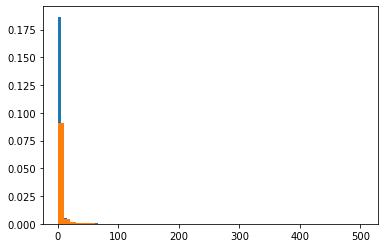

In [18]:
vals = x['edge_attrs'][:,0]
h = plt.hist(vals[vals!=0],bins = 50,density=True)

vals = x['edge_attrs'][:,1]
h = plt.hist(vals[vals!=0],bins = 50,density=True)

/disk1/dh486/anaconda3/envs/hicexplorer/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


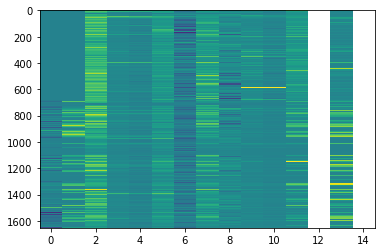

In [19]:
im = x['site_features']  
norm = (np.repeat(np.max(abs(im),
                         axis = 0)[None,:],
                   im.shape[0],
                   axis = 0
                   )
)

im = im/norm
plt.imshow(im, aspect='auto')

In [122]:
x['edge_index'].shape[1]

864299

In [120]:
import networkx as nx
G = nx.Graph()
G.add_nodes_from([(idx,
                   {sfname: im[idx,jdx] for jdx, sfname in enumerate(x['site_feature_names'])}) for idx in np.arange(x['name'].shape[0])])
nx.set_node_attributes(G, {node:x['name'][node] for node in G.nodes()}, 'id')
G.add_edges_from([(x['edge_index'][0,idx],
                   x['edge_index'][1,idx],
                   {'WT_weight':x['edge_attrs'][idx,0],
                    'KO_weight':x['edge_attrs'][idx,1],
                    'mean_weight':x['edge_attrs'][idx,2]}) for idx in np.arange(x['edge_index'].shape[1])])

KeyboardInterrupt: 

In [124]:
G.nodes(data=True)[2500]

{'WT_rnaseq': 0.2860080634359302,
 'KO_rnaseq': 0.2909444812618878,
 'lfc_rnaseq': -0.02029773080434698,
 'Mbd3': 0.18503223142333866,
 'CTCF_WT': 0.038266245114296465,
 'CTCF_KO': 0.04363191026288969,
 'Smc3_WT': 0.05484486554772877,
 'Smc3_KO': 0.03858649412038817,
 'H3K27ac_0h': 0.3914158561876769,
 'H3K27ac_1h': 0.33160716691756686,
 'H3K27ac_24h': 0.3029659731569443,
 'H3K27ac_48h': 0.3065592608415129,
 'Nanog_WT': 0.031901928330735484,
 'Nanog_KO': 0.045316479495800574,
 'Klf4_WT': 0.09279056816626777,
 'Klf4_KO': 0.39517804938066264,
 'H3K4me3_0h': 0.7869962949710537,
 'H3K4me3_24h': 0.8175343240484754,
 'id': 'promoter_ENSMUSG00000038866'}

In [115]:
H = nx.Graph()
H.add_nodes_from([1,2,3,4,5])
H.add_edges_from([(1,2,{'KO_weight':5,'WT_weight':3,'mean':4}),
                  (3,5,{'KO_weight':2,'WT_weight':8,'mean':1})
                 ])

In [ ]:
H.edges(data=True)[(1,2)]

In [5]:
import glob
import pandas as pd
import numpy as np

x = pd.read_table('/disk1/dh486/Data/rnaseq/kallisto_ncrna_ERCC92_wayne_processed_abundance_norm.txt')
x

,chromosome,prom_start,prom_end,transcript_start,transcript_end,ens_id,lfc,strand,log10KO_exp,log10WT_exp,name
0,3,108145651,108147137,108107280,108146151,ENSMUSG00000000001,0.052546,-1,1.722002,1.774547,Gnai3
1,X,77853128,77854614,77837901,77853628,ENSMUSG00000000003,-0.002751,-1,0.001375,-0.001375,Pbsn
2,16,18811096,18812978,18780447,18811596,ENSMUSG00000000028,-0.112532,-1,1.700354,1.587822,Cdc45
3,7,142576415,142579134,142575529,142576915,ENSMUSG00000000031,0.528073,-1,0.460089,0.988163,H19
4,X,161161759,161163555,161163055,161258213,ENSMUSG00000000037,-0.474546,1,1.329332,0.854785,Scml2
...,...,...,...,...,...,...,...,...,...,...,...
41464,17,29548808,29550294,29549794,29682012,ENSMUSG00000099329,-0.014677,1,0.013417,-0.001259,Gm28052
41465,7,44537683,44539169,44538106,44538183,ENSMUSG00000099330,0.427555,-1,-0.002683,0.424872,Mir7053
41466,11,46169096,46170582,46170082,46170143,ENSMUSG00000099331,-0.002751,1,0.001375,-0.001375,Mir7239
41467,17,85617076,85618562,85618062,85618265,ENSMUSG00000099332,-0.002751,1,0.001375,-0.001375,Gm27502


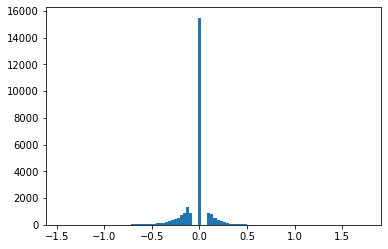

In [25]:
import matplotlib.pyplot as plt 
idxs = abs(x['lfc'].values) > np.percentile(abs(x['lfc'].values),75)
jdxs = abs(x['lfc'].values) < np.percentile(abs(x['lfc'].values[x['lfc'].values>0]),10)
x = x.loc[idxs|jdxs]
h = plt.hist(np.diff(x[['log10KO_exp','log10WT_exp']].values,axis = 1),bins = 100)

In [26]:
h[1][np.argmax(h[0]):np.argmax(h[0])+2]

array([-0.01210158,  0.01987996])

In [11]:
import itertools

rnaseq = pd.read_csv('Data/rnaseq.tsv',sep = "\t")
idxs = abs(rnaseq['lfc'].values) > np.percentile(abs(rnaseq['lfc'].values),75)
jdxs = abs(rnaseq['lfc'].values) < np.percentile(abs(rnaseq['lfc'].values[rnaseq['lfc'].values>0]),10)
rnaseq = rnaseq.loc[idxs|jdxs]

prom_regions = {k1: np.concatenate([item[None,1:3] for item in list(g1)],
                                        axis = 0).astype('int32') for k1,g1 in itertools.groupby(sorted(rnaseq.values,key = lambda x:x[0]),lambda x: x[0])}

target = {k1: np.concatenate([item[None,[3]] for item in list(g1)],
                                        axis = 0).astype('float')[:,0] for k1,g1 in itertools.groupby(sorted(rnaseq.values,key = lambda x:x[0]),lambda x: x[0])}
names = {k1: np.concatenate([item[None,[4]] for item in list(g1)],
                                        axis = 0)[:,0] for k1,g1 in itertools.groupby(sorted(rnaseq.values,key = lambda x:x[0]),lambda x: x[0])}

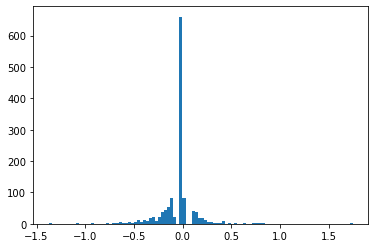

In [27]:
h= plt.hist(target['chr1'],bins = 100)

In [27]:
from sklearn.preprocessing import PowerTransformer as PT
from sklearn.preprocessing import StandardScaler as SS
from sklearn.preprocessing import RobustScaler as RS

import numpy as np

def PowerTransform_norm(arr, skip_negs=True):
    negs = np.sum(arr<0,axis = 0)>0
    if not skip_negs:
        arrs[negs,:] -= np.min(arrs[negs,:],axis = 1)
        negs = np.sum(arr<0,axis = 0)>0
    
    scalerPT = PT(method = 'box-cox')
    
    scaler_arr = arr[:,~negs]
    scaler_arr = scaler_arr+0.01*np.min(scaler_arr[scaler_arr>0])
    scalerPT.fit(scaler_arr)
    
    arrPT = arr.copy()
    arrPT[:,~negs] = scalerPT.transform(scaler_arr)
    
    return arrPT

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_table("Data/_candidate_elements.csv")

In [23]:
df

,chrom,start,end,id,WT_rnaseq,KO_rnaseq,lfc_rnaseq,Mbd3,CTCF_WT,CTCF_KO,...,H3K27ac_0h,H3K27ac_1h,H3K27ac_24h,H3K27ac_48h,Nanog_WT,Nanog_KO,Klf4_WT,Klf4_KO,H3K4me3_0h,H3K4me3_24h
0,chr1,4470904,4472493,intergenic,0.000000,0.000000,0.000000,1.487327,0.095444,0.061861,...,0.359405,0.407135,0.174064,0.261917,5.477067,7.062288,4.894259,6.060658,0.179511,0.123553
1,chr1,4571442,4572012,intergenic,0.000000,0.000000,0.000000,2.830772,0.179322,0.107228,...,0.434321,0.325917,0.237537,0.467078,2.021053,5.463639,8.814035,16.129548,4.298280,4.977712
2,chr1,4659374,4662004,intergenic,0.000000,0.000000,0.000000,1.097706,0.056956,0.043290,...,0.874836,1.380418,0.666807,0.394889,5.149150,5.486551,5.542861,3.886985,0.140405,0.083085
3,chr1,4800080,4805026,intergenic,0.000000,0.000000,0.000000,0.828755,0.057249,0.060674,...,1.289588,2.162160,0.974290,0.562574,11.655971,5.633804,6.462882,3.379700,0.117639,0.086481
4,chr1,4971591,4972402,intergenic,0.000000,0.000000,0.000000,0.631140,0.089263,0.067885,...,0.443815,0.778908,0.391913,0.042240,6.236745,2.889230,2.007398,0.892260,0.078947,0.051712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59720,chrY,90400257,90401743,promoter_ENSMUSG00000096178,-0.001375,0.001375,-0.002751,0.011772,0.002777,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
59721,chrY,90752066,90753552,promoter_ENSMUSG00000095134,0.183686,0.316517,-0.132830,0.005358,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
59722,chrY,90754972,90756458,promoter_ENSMUSG00000095366,0.492786,0.510529,-0.017744,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
59723,chrY,90783747,90785233,promoter_ENSMUSG00000096768,2.662188,2.688566,-0.026378,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000242,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [24]:
new_df = df[['chrom','start','end','id','lfc_rnaseq']].copy()
new_df['mean_exp'] = df[['WT_rnaseq','KO_rnaseq']].mean(axis = 1)
new_df['Mbd3'] = df['Mbd3'].copy()
for track in ['CTCF','Smc3','Klf4','Nanog']:
    new_df[f'{track}_mean'] = df[[f'{track}_WT',f'{track}_KO']].mean(axis = 1)
    new_df[f'{track}_diff'] = df[f'{track}_WT'] - df[f'{track}_KO']

new_df['H3K27ac_mean'] = df[['H3K27ac_0h','H3K27ac_48h']].mean(axis = 1)
new_df['H3K27ac_diff'] = df['H3K27ac_48h']- df['H3K27ac_0h']

new_df['H3K4me3_mean'] = df[['H3K4me3_0h','H3K4me3_24h']].mean(axis = 1)
new_df['H3K4me3_diff'] = df['H3K4me3_24h']- df['H3K4me3_0h']


In [25]:
new_df

,chrom,start,end,id,lfc_rnaseq,mean_exp,Mbd3,CTCF_mean,CTCF_diff,Smc3_mean,Smc3_diff,Klf4_mean,Klf4_diff,Nanog_mean,Nanog_diff,H3K27ac_mean,H3K27ac_diff,H3K4me3_mean,H3K4me3_diff
0,chr1,4470904,4472493,intergenic,0.000000,0.000000e+00,1.487327,0.078653,0.033584,0.080151,-0.020105,5.477459,-1.166399,6.269678,-1.585221,0.310661,-0.097488,0.151532,-0.055958
1,chr1,4571442,4572012,intergenic,0.000000,0.000000e+00,2.830772,0.143275,0.072094,0.152390,-0.005538,12.471791,-7.315513,3.742346,-3.442586,0.450700,0.032757,4.637996,0.679432
2,chr1,4659374,4662004,intergenic,0.000000,0.000000e+00,1.097706,0.050123,0.013666,0.066474,-0.013309,4.714923,1.655876,5.317850,-0.337401,0.634862,-0.479946,0.111745,-0.057320
3,chr1,4800080,4805026,intergenic,0.000000,0.000000e+00,0.828755,0.058961,-0.003425,0.068578,-0.013016,4.921291,3.083182,8.644887,6.022167,0.926081,-0.727014,0.102060,-0.031158
4,chr1,4971591,4972402,intergenic,0.000000,0.000000e+00,0.631140,0.078574,0.021378,0.073020,0.008826,1.449829,1.115139,4.562987,3.347515,0.243027,-0.401575,0.065330,-0.027235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59720,chrY,90400257,90401743,promoter_ENSMUSG00000096178,-0.002751,-4.987330e-18,0.011772,0.001388,0.002777,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
59721,chrY,90752066,90753552,promoter_ENSMUSG00000095134,-0.132830,2.501017e-01,0.005358,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
59722,chrY,90754972,90756458,promoter_ENSMUSG00000095366,-0.017744,5.016574e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
59723,chrY,90783747,90785233,promoter_ENSMUSG00000096768,-0.026378,2.675377e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [26]:
new_df.to_csv("Data/candidate_elements.csv",sep="\t",index = False)

In [73]:
new_df2 = new_df[['chrom','start','end','id','lfc_rnaseq']].copy()
new_df2['mean_exp'] = new_df['mean_exp'].copy()
new_df2['Mbd3'] = PowerTransform_norm(new_df['Mbd3'].copy().values)
for track in ['CTCF','Smc3','Klf4','Nanog','H3K27ac','H3K4me3']:
    new_df2[f'{track}_mean'] = PowerTransform_norm(new_df[f'{track}_mean'].copy().values)
    new_df2[f'{track}_diff'] = SS().fit_transform(new_df[f'{track}_diff'].copy().values[:,None])
    
new_df2
new_df2.to_csv("Data/candidate_elements_scaled.csv",sep="\t",index = False)

In [71]:
vals = new_df2['Mbd3'].values

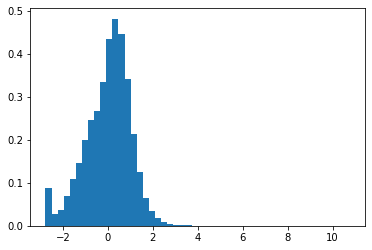

In [72]:
h = plt.hist(vals,density=True, bins = 50)

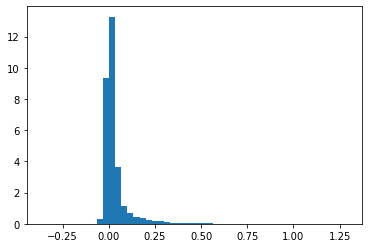

In [66]:
tmp = new_df['CTCF_diff'].values[:,None]
scal = SS().fit(tmp[tmp!=0][:,None])
vals = scal.transform(tmp)
h = plt.hist(tmp,density=True, bins = 50)

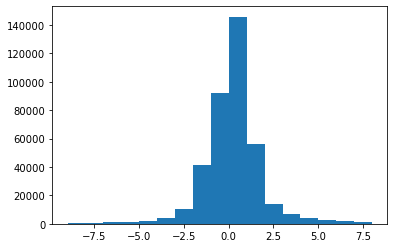

In [50]:
vals = x['edge_attrs'][:,0]-x['edge_attrs'][:,1]
THRESH = np.percentile(abs(vals),98)
h = plt.hist(vals[vals!=0],bins = np.arange(-THRESH,THRESH))

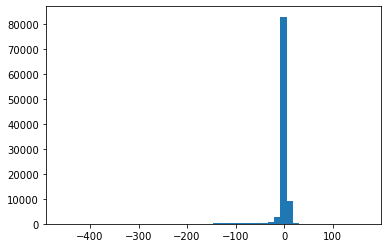

In [80]:
vals = x['edge_attrs'][:,2]
THRESH = np.percentile(vals,75)

idxs = vals>THRESH

vals2 = x['edge_attrs'][idxs,0]-x['edge_attrs'][idxs,1]
h = plt.hist(vals2,bins = 50)

In [78]:
THRESH

1.0846319826336601

(array([2.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        4.0000e+00, 4.0000e+00, 1.1000e+01, 2.5000e+01, 1.2000e+01,
        2.9000e+01, 3.4000e+01, 7.9000e+01, 9.0000e+01, 1.2700e+02,
        2.3500e+02, 2.9800e+02, 4.2600e+02, 6.7400e+02, 1.1200e+03,
        1.8970e+03, 3.9920e+03, 4.3596e+04, 3.7550e+03, 1.6680e+03,
        7.7400e+02, 3.6900e+02, 1.6200e+02, 1.3400e+02, 8.9000e+01,
        3.2000e+01, 1.7000e+01, 2.6000e+01, 1.1000e+01, 9.0000e+00,
        9.0000e+00, 3.0000e+00, 3.0000e+00, 4.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-1.45127083, -1.38730775, -1.32334467, -1.2593816 , -1.19541852,
        -1.13145544, -1.06749236, -1.00352928, -0.93956621, -0.87560313,
        -0.81164005, -0.74767697, -0.6837139 , -0.61975082, -0.55578774,
        -0.49182466, -0.42786158, -0.36389851, -0.29993543, -0.23597235,
        -0.17200927, -0.10

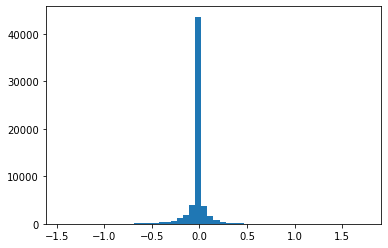

In [84]:
plt.hist(new_df2['lfc_rnaseq'].values,bins = 50)